# Индексатор файлов

Нужно проиндексировать файлы с изображениями в директории templates.

Индекс будет строится на основании цветности изображения (grayscale, color), доминирующего цвета (red, green, blue, none) и СКО нормированной гистограммы, построенной для grayscale представления.

In [1]:
import skimage.exposure
from skimage.color import rgb2gray
import imageio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

TEMPLATES_DIR = 'templates'
UNSORTED_DIR = 'unsorted'

# returns scale for image 
def get_scale(img):
    if img.ndim == 2:
        return 'grayscale'
    return 'color'

# returns main color for image
# Main color is a color which has max value of  sum(bin * value) of unnormalize historgam
def get_main_color(img):
    rgb_tuple = ('red', 'green', 'blue')
    red_hist = skimage.exposure.histogram(img[:, :, 0])
    green_hist = skimage.exposure.histogram(img[:, :, 1])
    blue_hist = skimage.exposure.histogram(img[:, :, 2])

    intensity = np.array([(x * y).sum() for x, y in (hist for hist in (red_hist, green_hist, blue_hist))])
    if not all(intensity[2] == intensity[x] for x in range(2)):
        return rgb_tuple[intensity.argmax()]
    return 'none'

# returns gray index as std * 10^9 of normalized histogram for grayscale image
def get_gray_index(img):
    img_gray = rgb2gray(img)
    hist_grey = skimage.exposure.histogram(img_gray, normalize=True)
    return int(hist_grey[0].std() * 10 ** 9)


# data for buildig index stores in lists: scales, main_colors, grey_indexes
scales = []
main_colors = []
grey_indexes = []

# for each file in TEMPLATE_DIR define values for index and append them to lists
templates_list = os.listdir(TEMPLATES_DIR)
for tmpl in templates_list:
    pic = imageio.imread(f'{TEMPLATES_DIR}/{tmpl}')

    scale = get_scale(pic)
    main_color = get_main_color(pic)
    grey_index = get_gray_index(pic)

    scales.append(scale)
    main_colors.append(main_color)
    grey_indexes.append(grey_index)
    

В результате получим lists: scales, main_colors, grey_indexes, на основании которых построим индекс для templates_list.

Индекс находится в объекте multi_index, который используется при создании семантического кеша проиндексированных файлов.

In [2]:
multi_index = pd.MultiIndex.from_arrays([scales, main_colors, grey_indexes], names=['scale', 'main_color', 'gray_std'])

cache_index = pd.Series(data=templates_list, index=multi_index, name='file_name')

cache_index.sort_index(inplace=True)

cache_index

scale  main_color  gray_std
color  blue        2884447     photo-1438761681033-6461ffad8d80.png
                   3459922     photo-1504703395950-b89145a5425b.png
                   5524727     photo-1534528741775-53994a69daeb.png
                   5578756     photo-1517486808906-6ca8b3f04846.png
                   6446242                       zellforschung1.jpg
                   17272060    photo-1506277886164-e25aa3f4ef7f.png
       green       4635422     photo-1454923634634-bd1614719a7b.png
       none        41545913     99301 roof tile inside 3x3 395R.png
                   51353794                 3010 brick 1x4 026L.png
                   53082396                 3003 brick 2x2 159R.png
                   53579128         6143 Brick D16 w cross 120R.png
                   53622367                 3004 brick 1x2 046R.png
                   56107117                 3005 brick 1x1 100L.png
                   57587574                  6632 lever 3M 106R.png
                   5

# Семантический поиск

Возможны 2 режима поиска - с учетом цвета и без. 

Если цвет игнорируется, то поиск будет производиться в два этапа:
1 - по модулю разности в std гистограмм рассматриваемого изображения и файлов из templates - выбираем 20 файлов с наименьшей разностью
2 - вычисляем сумму абсолютных разностей между гистограммами, выбираем 3 с минимальной разностью.

Если цвет не игнорируется, то у изображений должен совпадать доминирующий цвет. Остальное - так же как и при игнорировании цвета

In [3]:
def hist_compare(*args):
    arrays = tuple([np.zeros(256) for _ in range(2)])
    for h, ar in zip(args, arrays):
        for i, bn in enumerate(h[1]):
            ar[bn] = h[0][i]
    diff_array = abs(arrays[0] - arrays[1])
    return diff_array.sum()


image = 'photo-1529626455594-4ff0802cfb7e.png'
color_ignore = True

#the first stage of search
image_to_sort = imageio.imread(f'{UNSORTED_DIR}/{image}')

curr_scale = get_scale(image_to_sort)
curr_grey_index = get_gray_index(image_to_sort)

if color_ignore:
    gray_index_array = np.array(cache_index.index.levels[2])
    file_names = cache_index.to_list()
else:
    curr_main_color = get_main_color(image_to_sort)
    gray_index_array = np.array(cache_index['color'][curr_main_color].index)
    file_names = cache_index['color'][curr_main_color].to_list()
    
data = zip(abs(gray_index_array - curr_grey_index), file_names)
diff_std = pd.DataFrame(data=data, index=list(gray_index_array), columns=['diff_std', 'file_name'])
diff_std.sort_values(by='diff_std', inplace=True)

#the second stage of search
sample = diff_std[:min(20, len(diff_std))]
hist_diffs = []
sample_file_names = sample['file_name']
sample_indexes = sample.index

for f in file_names:
    image_file = imageio.imread(f'{TEMPLATES_DIR}/{f}')
    hist_file = skimage.exposure.histogram(image_file, normalize=True)
    hist_grey = skimage.exposure.histogram(image_to_sort, normalize=True)
    hist_diff = hist_compare(hist_grey, hist_file)
    hist_diffs.append(hist_diff)

data = zip(hist_diffs, sample_file_names)
diff = pd.DataFrame(data=data, index=sample_indexes, columns=['diff_hist', 'file_name'])
diff.sort_values(by='diff_hist', inplace=True)

/opt/anaconda3/envs/datalore-user/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
/opt/anaconda3/envs/datalore-user/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.


# Визуализация

Изображение, для которого выполнялся поиск - Sorting

Ближайшие 3 соответствия - First - Third

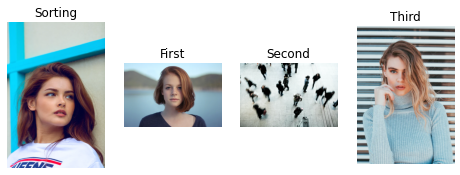

In [4]:
file_names_list = diff['file_name'][:min(3, len(diff))].to_list()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(8, 3))
for aa in (ax1, ax2, ax3, ax4):
    aa.set_axis_off()

ax1.imshow(imageio.imread(f'{UNSORTED_DIR}/{image}'))
ax1.set_title('Sorting')
try:
    ax2.imshow(imageio.imread(f"{TEMPLATES_DIR}/{file_names_list[0]}"))
    ax2.set_title('First')
    ax3.imshow(imageio.imread(f"{TEMPLATES_DIR}/{file_names_list[1]}"))
    ax3.set_title('Second')
    ax4.imshow(imageio.imread(f"{TEMPLATES_DIR}/{file_names_list[2]}"))
    ax4.set_title('Third')
except IndexError:
    pass